# Variational Auto-Encoder

### Sources

##### VAE Specific

https://debuggercafe.com/convolutional-variational-autoencoder-in-pytorch-on-mnist-dataset/

https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/

https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd


##### CNN in General

Testing/Validation: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/cifar-cnn/cifar10_cnn_solution.ipynb

Theory: https://cs231n.github.io/convolutional-networks/#conv

Theory/AE Class: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/autoencoder/convolutional-autoencoder/Convolutional_Autoencoder_Solution.ipynb

Theory/AE Class: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/cifar-cnn/cifar10_cnn_solution.ipynb

### Imports

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
from collections import OrderedDict
from pathlib import Path
import uuid
#import pydicom
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Import essential libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
#from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time
import random
%matplotlib inline
import torch.nn as nn
import torch.optim as optim
import gzip

### Data Preparation

In [2]:
cxr_root_path = "/media/Data/ComputerVision/mimic_cxr_jpg_small_chest_radiograph/data/physionet.org/files/mimic-cxr-jpg/2.0.0/"
record_df = pd.read_csv('{}/cxr-record-list.csv.gz'.format(cxr_root_path), sep=',')
record_df.head()

,subject_id,study_id,dicom_id,path
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...
1,10000032,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,files/p10/p10000032/s50414267/174413ec-4ec4c1f...
2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded15...
3,10000032,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,files/p10/p10000032/s53189527/e084de3b-be89b11...
4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d048...


In [3]:
df_split = pd.read_csv('{}/mimic-cxr-2.0.0-split.csv.gz'.format(cxr_root_path))
dataset = df_split.merge(record_df, on=['subject_id', 'study_id', 'dicom_id'], how='left')
num_images=len(dataset)
print(num_images)

377110


### Selecting Portion of Data

In [4]:
dataset=dataset[0:1000]

### Selecting Device

In [5]:
import torch.optim as optim
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
class CustomDatasetFromImages(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms=None): 
        self.dataframe = dataframe
        self.transforms = transforms
    def __getitem__(self, index):
        imagepath=self.dataframe["path"].iloc[index]
        imagepath=cxr_root_path+imagepath[:-4]+'.jpg'
        image=Image.open(imagepath)
        if self.transforms is not None:
            image=self.transforms(image)
        return image
    def __len__(self):
        return len(self.dataframe)

In [7]:
train_Aug = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                            torchvision.transforms.RandomRotation((-20, 20)),
                                            torchvision.transforms.ToTensor()])
test_Aug = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),torchvision.transforms.ToTensor()])

In [8]:
train_set=CustomDatasetFromImages(dataset.loc[dataset['split']=='train'], transforms=train_Aug)
test_set=CustomDatasetFromImages(dataset.loc[dataset['split']=='validate'], transforms=test_Aug)
trainloader= torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=6,shuffle=True) 
testloader= torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=6,shuffle=False)

In [9]:
import torch.nn as nn
import torch.nn.functional as F


#variables
kernel_size = 3 # (4, 4) kernel
init_channels = 8 # initial number of filters
image_channels = 1 # images are grayscale
latent_dim = 16 # latent dimension for sampling

# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
         padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, 
            padding=1
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=2
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2
        )
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape #no idea
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1) #no idea what this does 
        hidden = self.fc1(x)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var) #sample
        z = self.fc2(z) #no idea why 
        z = z.view(-1, 64, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var


### Loss Function

In [10]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss=BCE + KLD
    return total_loss

In [11]:
learning_rate = 1e-3

In [12]:
# number of epochs to train the model
torch.cuda.empty_cache()
n_epochs = 5

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model=ConvVAE().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.BCELoss(reduction='sum')

### Training and Validation

In [13]:
valid_loss_min = np.Inf # track change in validation loss
train_loss_list=[]
valid_loss_list=[]
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for data in trainloader:
        # move tensors to GPU if CUDA is available
        # clear the gradients of all optimized variables
        data=data.to(device)
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
        
    # validate the model #
    model.eval()
    for data in testloader:
        # move tensors to GPU if CUDA is available
        # forward pass: compute predicted outputs by passing inputs to the model
        data=data.to(device)
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(testloader.sampler)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

ValueError: Using a target size (torch.Size([64, 1, 224, 224])) that is different to the input size (torch.Size([64, 1, 31, 31])) is deprecated. Please ensure they have the same size.

### Plotting Loss Function across epochs

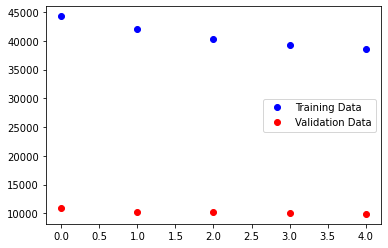

In [14]:
#print(train_loss_list[0])
plt.plot(range(0,5),train_loss_list,'bo')
plt.plot(range(0,5),valid_loss_list,'ro')
plt.legend(['Training Data','Validation Data'])
plt.show()

### Plotting validation results

ValueError: cannot reshape array of size 256 into shape (128,128)

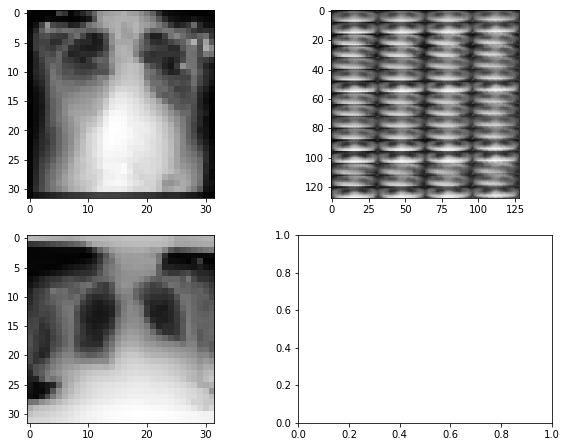

In [16]:
with torch.no_grad():
    # obtain one batch of test images
    dataiter = iter(testloader)
    images= dataiter.next()
    images.numpy()

    # move model inputs to cuda, if GPU available
    images = images.cuda()

    # get sample outputs
    output = model(images)

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(10, 20))
    for idx in range(5):
        ax = fig.add_subplot(5,2, 1+2*idx)
        im=np.reshape(images[idx].cpu(),(32,32))
        ax.imshow(im,cmap='gray')
        ax2 = fig.add_subplot(5,2, 2+2*idx)
        im2=np.reshape(output[idx].cpu(),(128,128))
        ax2.imshow(im2,cmap='gray')
    fig.tight_layout()
    